In [ ]:
import pandas as pd
import numpy as np

path = "/Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/Task 3 and 4_Loan_Data.csv"
df = pd.read_csv(path)

# --- Define a simple 1-D k-means (MSE) bucketer ---
def kmeans_1d_boundaries(fico, K=10, max_iter=100):
    x = np.sort(fico.astype(float))
    qs = np.linspace(0, 1, K + 2)[1:-1]
    centers = np.quantile(x, qs)
    for _ in range(max_iter):
        mids = (centers[:-1] + centers[1:]) / 2 if K > 1 else np.array([])
        bounds = list(mids) + [float("inf")]
        labels = np.zeros_like(x, dtype=int)
        j = 0
        for i, val in enumerate(x):
            while j < K - 1 and val > bounds[j]:
                j += 1
            labels[i] = j
        new_centers = np.array([x[labels == k].mean() if np.any(labels == k) else centers[k] for k in range(K)])
        if np.allclose(new_centers, centers):
            break
        centers = new_centers
    mids = (centers[:-1] + centers[1:]) / 2 if K > 1 else np.array([])
    return list(mids) + [float("inf")]

# --- Assign ratings ---
def assign_ratings(fico, boundaries):
    K = len(boundaries)
    idx = np.zeros_like(fico, dtype=int)
    for i, val in enumerate(fico):
        j = 0
        while j < K - 1 and val > boundaries[j]:
            j += 1
        idx[i] = j
    # Convert to ratings (1 = best / highest FICO)
    return (K - idx).astype(int)

# --- Apply the bucketing ---
K = 10
fico = df["fico_score"].values
default = df["default"].values

boundaries = kmeans_1d_boundaries(fico, K)
df["rating"] = assign_ratings(fico, boundaries)

# --- Summarize results ---
bucket_stats = []
for r in range(1, K+1):
    mask = df["rating"] == r
    n = mask.sum()
    k = default[mask].sum()
    pd_hat = (k + 0.5) / (n + 1.0)
    bucket_stats.append((r, n, pd_hat))

print("\n=== FICO Bucketer (MSE / 1-D k-means) ===")
for i, b in enumerate(boundaries, start=1):
    print(f"Bucket {i}: <= {b if np.isfinite(b) else '+inf'}")
print("\nCounts & PD per rating (1 = best):")
for r, n, p in bucket_stats:
    print(f"Rating {r}: n={n}, PD≈{p:.4f}")

# --- Save new CSV ---
output_path = "/Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/Loan_Data_with_Ratings.csv"
df.to_csv(output_path, index=False)
print(f"\nSaved file: {output_path}")



=== FICO Bucketer (MSE / 1-D k-means) ===
Bucket 1: <= 522.1527470874742
Bucket 2: <= 563.5022264968347
Bucket 3: <= 593.0631483051272
Bucket 4: <= 617.1746612549907
Bucket 5: <= 638.7492390605951
Bucket 6: <= 660.9064872389374
Bucket 7: <= 685.957616961432
Bucket 8: <= 715.6162624289609
Bucket 9: <= 755.4448037142974
Bucket 10: <= +inf

Counts & PD per rating (1 = best):
Rating 1: n=231, PD≈0.0194
Rating 2: n=731, PD≈0.0403
Rating 3: n=1192, PD≈0.0767
Rating 4: n=1409, PD≈0.0954
Rating 5: n=1424, PD≈0.1253
Rating 6: n=1364, PD≈0.1769
Rating 7: n=1328, PD≈0.2163
Rating 8: n=1201, PD≈0.2933
Rating 9: n=793, PD≈0.4087
Rating 10: n=327, PD≈0.6448

Saved file: /Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/Loan_Data_with_Ratings.csv


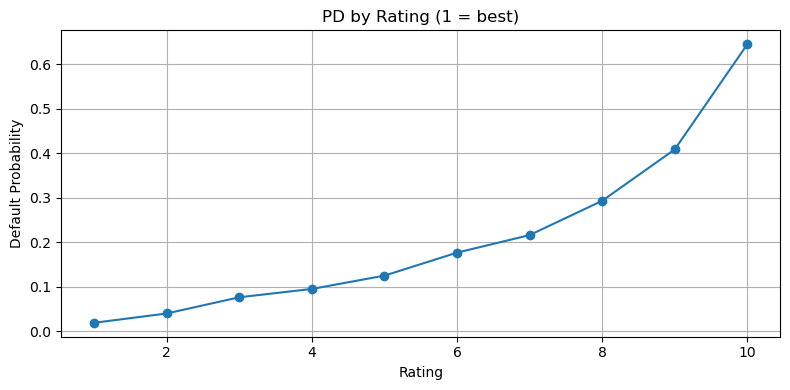

In [2]:
import matplotlib.pyplot as plt

ratings = list(range(1, 11))
pd_vals = [0.0194, 0.0403, 0.0767, 0.0954, 0.1253, 0.1769, 0.2163, 0.2933, 0.4087, 0.6448]

plt.figure(figsize=(8,4))
plt.plot(ratings, pd_vals, marker="o")
plt.title("PD by Rating (1 = best)")
plt.xlabel("Rating")
plt.ylabel("Default Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import json

# Save boundaries
bpath = "/Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/fico_boundaries_mse.json"
with open(bpath, "w") as f:
    json.dump(boundaries, f)
print("Saved boundaries ->", bpath)


Saved boundaries -> /Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/fico_boundaries_mse.json


In [5]:
# Load saved boundaries
bpath = "/Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/fico_boundaries_mse.json"
with open(bpath, "r") as f:
    boundaries = json.load(f)

# Re-load your same loan dataset
new_df = pd.read_csv("/Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/Task 3 and 4_Loan_Data.csv")

# Apply same rating map
def apply_ratings(fico_series, boundaries):
    K = len(boundaries)
    out = np.empty(len(fico_series), dtype=int)
    for i, val in enumerate(fico_series.values):
        j = 0
        while j < K-1 and val > boundaries[j]:
            j += 1
        out[i] = K - j  # 1 = best
    return out

new_df["rating"] = apply_ratings(new_df["fico_score"], boundaries)

# Save again (or overwrite)
out_path = "/Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/Loan_Data_with_Ratings_Reapplied.csv"
new_df.to_csv(out_path, index=False)
print("✅ Reapplied ratings and saved:", out_path)

✅ Reapplied ratings and saved: /Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/Loan_Data_with_Ratings_Reapplied.csv


In [6]:

# --- Step 1: Load saved boundaries ---
bpath = "/Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/fico_boundaries_mse.json"
with open(bpath, "r") as f:
    boundaries = json.load(f)

# --- Step 2: Load your dataset ---
path = "/Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/Task 3 and 4_Loan_Data.csv"
df = pd.read_csv(path)

# --- Step 3: Function to apply ratings ---
def apply_ratings(fico_series, boundaries):
    K = len(boundaries)
    out = np.empty(len(fico_series), dtype=int)
    for i, val in enumerate(fico_series.values):
        j = 0
        while j < K - 1 and val > boundaries[j]:
            j += 1
        out[i] = K - j  # 1 = best
    return out

# --- Step 4: Apply and save ---
df["rating"] = apply_ratings(df["fico_score"], boundaries)

out_path = "/Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/Loan_Data_with_Ratings_Reapplied.csv"
df.to_csv(out_path, index=False)
print("✅ Reapplied ratings and saved:", out_path)

# --- Step 5: Print borrower counts + average PD per rating ---
summary = df.groupby("rating")["default"].agg(["count", "mean"]).reset_index()
summary.rename(columns={"count": "Borrowers", "mean": "Avg_PD"}, inplace=True)

print("\n📊 Borrower Distribution by Rating:")
print(summary.to_string(index=False, formatters={"Avg_PD": "{:.3f}".format}))


✅ Reapplied ratings and saved: /Users/gracepolito/Desktop/Master of Data Science/JP Morgan - Forage/Loan_Data_with_Ratings_Reapplied.csv

📊 Borrower Distribution by Rating:
 rating  Borrowers Avg_PD
      1        231  0.017
      2        731  0.040
      3       1192  0.076
      4       1409  0.095
      5       1424  0.125
      6       1364  0.177
      7       1328  0.216
      8       1201  0.293
      9        793  0.409
     10        327  0.645


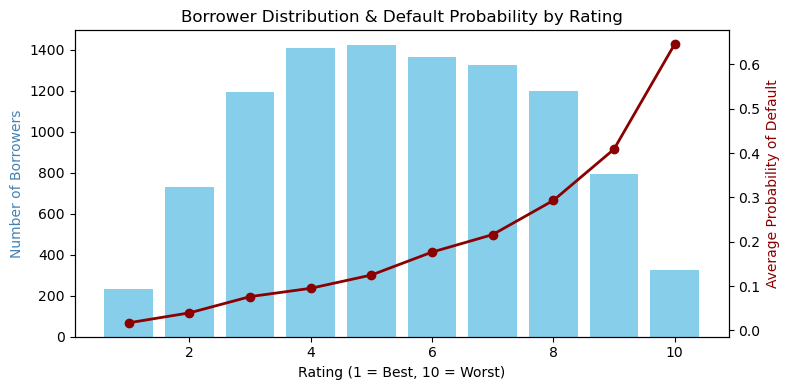

In [9]:
import matplotlib.pyplot as plt

# --- Step 6: Plotting ---
fig, ax1 = plt.subplots(figsize=(8, 4))

# Bar chart: borrower count per rating
ax1.bar(summary["rating"], summary["Borrowers"], color="skyblue", label="Borrowers")
ax1.set_xlabel("Rating (1 = Best, 10 = Worst)")
ax1.set_ylabel("Number of Borrowers", color="steelblue")

# Line chart: average PD per rating
ax2 = ax1.twinx()
ax2.plot(summary["rating"], summary["Avg_PD"], color="darkred", marker="o", linewidth=2, label="Avg PD")
ax2.set_ylabel("Average Probability of Default", color="darkred")

plt.title("Borrower Distribution & Default Probability by Rating")
fig.tight_layout()
plt.show()